In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools

# Data directories

In [2]:
# Data global directories
dir_interchrom = '../../data/hic/IMR90_interchromosomal/250kb_resolution_interchromosomal/'
dir_quality = 'MAPQGE30/' #'MAPQG0/'

In [3]:
# Choose a particular chromosome pair
chr1 = 10
chr2 = 11

In [4]:
# Choose a particular resolution
resol = int(2.5e5)
resol_str = '250kb'

In [5]:
# Define data directories for the chromosome pair
chrom_pair_dir = 'chr'+str(chr1)+'_'+'chr'+str(chr2)+'/'
data_dir = dir_interchrom + chrom_pair_dir + dir_quality
raw_mat_path = data_dir+'chr'+str(chr1)+'_'+str(chr2)+'_'+resol_str+'.RAWobserved'
KRnorm_chr1_path = data_dir+'chr'+str(chr1)+'_'+resol_str+'.KRnorm'
KRnorm_chr2_path = data_dir+'chr'+str(chr2)+'_'+resol_str+'.KRnorm'

In [6]:
# Print paths
print(raw_mat_path)
print(KRnorm_chr1_path)
print(KRnorm_chr2_path)

../../data/hic/IMR90_interchromosomal/250kb_resolution_interchromosomal/chr10_chr11/MAPQGE30/chr10_11_250kb.RAWobserved
../../data/hic/IMR90_interchromosomal/250kb_resolution_interchromosomal/chr10_chr11/MAPQGE30/chr10_250kb.KRnorm
../../data/hic/IMR90_interchromosomal/250kb_resolution_interchromosomal/chr10_chr11/MAPQGE30/chr11_250kb.KRnorm


# Load chromosome sizes

Chromosome sizes can be obtained from https://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/

In [7]:
# Get chromosome size
sizes_filename = '../../data/genome_data/chrom_hg19.sizes'
df_sizes = pd.read_csv(sizes_filename, sep = '\t', header = None, names=['chr','size'])
df_sizes['chr'] = df_sizes['chr'].str.split('chr',expand=True)[1]
df_sizes['size_loci'] = np.ceil(df_sizes['size']/250000).astype(int)
df_sizes = df_sizes[~df_sizes['chr'].str.contains('hap|alt|Un|rand')]
df_sizes

,chr,size,size_loci
0,1,249250621,998
1,2,243199373,973
2,3,198022430,793
3,4,191154276,765
4,5,180915260,724
5,6,171115067,685
6,7,159138663,637
7,X,155270560,622
8,8,146364022,586
9,9,141213431,565


# Load raw Hi-C data

In [8]:
# Load raw data
data = np.loadtxt(raw_mat_path, delimiter = '\t')
row_ind = data[:,0]/resol
row_ind = row_ind.astype(int)
col_ind = data[:,1]/resol
col_ind = col_ind.astype(int)
contact_values = data[:,2]


In [9]:
# Safety checks
print('Number of loci present for chr1: '+str(len(np.unique(row_ind))))
print('Number of loci present for chr2: '+str(len(np.unique(col_ind))))

Number of loci present for chr1: 531
Number of loci present for chr2: 528


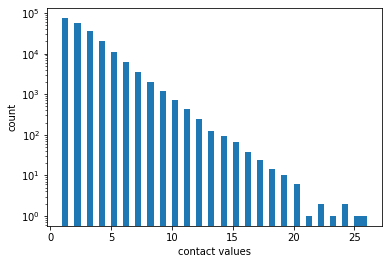

In [10]:
# Plot contact values histogram
plt.figure()
plt.hist(contact_values,50)
plt.xlabel('contact values')
plt.ylabel('count')
plt.yscale('log')
plt.show()

# Load normalization vectors

In [11]:
# Load normalization vectors
norm_chr1 = np.loadtxt(KRnorm_chr1_path, delimiter = '\t')
norm_chr2 = np.loadtxt(KRnorm_chr2_path, delimiter = '\t')

In [12]:
# Safety check (verify if number of loci per chromosome matches hg19 data from UCSC)
chr1_size = int(df_sizes[df_sizes['chr']==str(chr1)]['size_loci'])
chr2_size = int(df_sizes[df_sizes['chr']==str(chr2)]['size_loci'])
print('Length (in loci) of chr1 (from hg19): '+str(chr1_size))
print('Total number of loci for chr1: '+str(len(norm_chr1)-1))
print('Length (in loci) of chr2 (from hg19): '+str(chr2_size))
print('Total number of loci for chr2: '+str(len(norm_chr2)-1))

Length (in loci) of chr1 (from hg19): 543
Total number of loci for chr1: 543
Length (in loci) of chr2 (from hg19): 541
Total number of loci for chr2: 541


# Normalize raw Hi-C data

TODO: Understand why I do not get the same results as Anastasiya after normalization

In [13]:
# Convert Hi-C data to pandas dataframe
raw_hic_data = pd.DataFrame(data={'locus_chr1':row_ind,'locus_chr2':col_ind,'value':contact_values})
raw_hic_data.head()

,locus_chr1,locus_chr2,value
0,0,0,15.0
1,1,0,7.0
2,2,0,5.0
3,3,0,2.0
4,4,0,2.0


In [14]:
# Add columns corresponding to the normalizing factors for each entry
raw_hic_data['norm_locus_chr1'] = norm_chr1[raw_hic_data['locus_chr1']]
raw_hic_data['norm_locus_chr2'] = norm_chr2[raw_hic_data['locus_chr2']]
raw_hic_data.head()

,locus_chr1,locus_chr2,value,norm_locus_chr1,norm_locus_chr2
0,0,0,15.0,0.537635,0.445645
1,1,0,7.0,1.070878,0.445645
2,2,0,5.0,1.065181,0.445645
3,3,0,2.0,1.035501,0.445645
4,4,0,2.0,1.006773,0.445645


In [15]:
# Create normalized value
raw_hic_data['norm_value'] = raw_hic_data['value']/(raw_hic_data['norm_locus_chr1']*raw_hic_data['norm_locus_chr2'])
raw_hic_data.head()

,locus_chr1,locus_chr2,value,norm_locus_chr1,norm_locus_chr2,norm_value
0,0,0,15.0,0.537635,0.445645,62.605896
1,1,0,7.0,1.070878,0.445645,14.667944
2,2,0,5.0,1.065181,0.445645,10.533145
3,3,0,2.0,1.035501,0.445645,4.334021
4,4,0,2.0,1.006773,0.445645,4.457689


In [16]:
# Number of NaN normalized values
print('Number of NaN normalized values: '+str(np.sum(np.isnan(raw_hic_data['norm_value']))))

Number of NaN normalized values: 14


/home/louiscam/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/louiscam/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


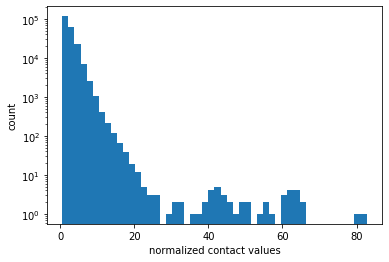

In [17]:
# Plot normalized contact values histogram
plt.figure()
plt.hist(raw_hic_data['norm_value'],50)
plt.xlabel('normalized contact values')
plt.ylabel('count')
plt.yscale('log')
plt.show()

In [18]:
# Save Hi-C dataframe to csv
filename = data_dir+'chr'+str(chr1)+'_'+str(chr2)+'_'+resol_str+'.KRobserved'
raw_hic_data.to_csv(filename, sep='\t', na_rep='', header=True)

# Form dense Hi-C dataframe

In [19]:
# Create dense Hi-C dataframe
hic_matrix = csr_matrix((raw_hic_data['norm_value'], (raw_hic_data['locus_chr1'], raw_hic_data['locus_chr2'])), 
                        shape = (chr1_size, chr2_size))
hic_dense = np.asarray(hic_matrix.todense())
row_labels = np.arange(chr1_size)*resol
col_labels = np.arange(chr2_size)*resol
df = pd.DataFrame(hic_dense, index = row_labels, columns = col_labels)
df = df.fillna(0)
df.head()

,0,250000,500000,750000,1000000,1250000,1500000,1750000,2000000,2250000,...,132750000,133000000,133250000,133500000,133750000,134000000,134250000,134500000,134750000,135000000
0,62.605896,16.397430,16.378051,8.793959,5.582416,18.580250,6.116312,6.560183,11.188324,0.000000,...,5.492073,0.000000,0.000000,4.359249,5.574047,3.478282,2.188934,3.945192,5.378288,0.0
250000,14.667944,14.112574,10.571921,8.830019,7.006634,1.332603,3.070696,6.587084,3.370261,3.769851,...,0.919099,0.000000,1.071314,2.188562,1.865635,4.365681,3.296866,3.961369,0.000000,0.0
500000,10.533145,16.552739,4.723765,11.096564,8.452935,5.358924,5.145203,5.518598,4.517718,5.685025,...,0.000000,0.000000,0.000000,1.100134,4.689035,0.877807,0.000000,1.991279,2.714614,0.0
750000,4.334021,8.513592,4.859160,4.565848,5.796812,5.512525,4.234142,3.406066,2.323604,5.847972,...,1.901000,0.000000,0.000000,0.000000,1.929374,4.514835,4.546004,0.000000,2.792422,0.0
1000000,4.457689,5.003727,2.498907,4.696132,4.471665,4.252366,3.266220,3.503255,5.974766,2.004947,...,1.955244,3.367685,0.000000,2.327917,4.961068,5.572395,1.168930,5.267008,1.436051,0.0


# Plot normalized Hi-C matrix

In [20]:
# Helper functions
def map_rownum2pos(df, row_num):
    positions = df.index.values
    return positions[row_num]

def map_colnum2pos(df, col_num):
    positions = df.columns.values
    return float(positions[col_num])

/home/louiscam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


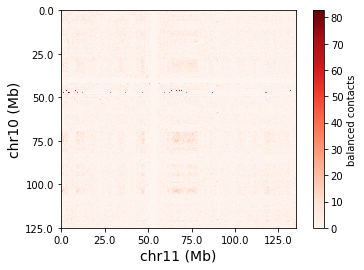

In [21]:
# Plot matrix
data = df.as_matrix()
plt.figure()
plt.imshow(data, cmap = 'Reds')
cbar = plt.colorbar()
cbar.set_label('balanced contacts')
cbar.solids.set_rasterized(True)

# label ticks with genomic position (Mb)
xaxis = range(0, df.shape[1], 100)
xlabels = [str(map_colnum2pos(df, x)/1000000.0) for x in xaxis]
plt.xticks(xaxis, xlabels)
yaxis = range(0, df.shape[0], 100)
ylabels = [str(map_rownum2pos(df, y)/1000000.0) for y in yaxis]
plt.yticks(yaxis, ylabels)

plt.xlabel('chr' + str(chr2) + ' (Mb)', fontsize = 14)
plt.ylabel('chr' + str(chr1) + ' (Mb)', fontsize = 14)

plt.show()

# Filter out peri-centromeric regions

Centromeric regions can be obtained from http://genome.ucsc.edu/cgi-bin/hgTables using the following filters:
- clade: mammal  
- genome: human  
- assembly: Feb 2009  
- group: mapping and sequencing tracks  
- track: gap  
- table: gap  
- region: genome  
- output format: all fields from selected table  
- filter: does match "centromere"

In [24]:
# Get centromeric locations
centrom_filename = '../../data/genome_data/chrom_hg19.centromeres'
df_centrom = pd.read_csv(centrom_filename, sep = '\t')
df_centrom.head()

,bin,chrom,chromStart,chromEnd,ix,n,size,type,bridge
0,23,chr1,121535434,124535434,1270,N,3000000,centromere,no
1,20,chr2,92326171,95326171,770,N,3000000,centromere,no
2,2,chr3,90504854,93504854,784,N,3000000,centromere,no
3,1,chr4,49660117,52660117,447,N,3000000,centromere,no
4,14,chr5,46405641,49405641,452,N,3000000,centromere,no


In [25]:
# For chromosome chr1
filter_size = 2000000
chr_data = df_centrom[df_centrom['chrom'] == 'chr' + str(chr1)]
centrom_start = int(math.floor(float(chr_data['chromStart'])/resol)*resol)
centrom_end = int(math.ceil(float(chr_data['chromEnd'])/resol)*resol)
centrom_start = centrom_start - filter_size
centrom_end = centrom_end + filter_size
df.loc[centrom_start:centrom_end, :] = 0

In [26]:
# For chromosome chr2
filter_size = 2000000
chr_data = df_centrom[df_centrom['chrom'] == 'chr' + str(chr2)]
centrom_start = int(math.floor(float(chr_data['chromStart'])/resol)*resol)
centrom_end = int(math.ceil(float(chr_data['chromEnd'])/resol)*resol)
centrom_start = centrom_start - filter_size
centrom_end = centrom_end + filter_size
df.loc[:,centrom_start:centrom_end] = 0

/home/louiscam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


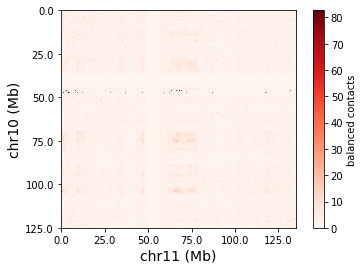

In [27]:
# Plot matrix
data = df.as_matrix()
plt.figure()
plt.imshow(data, cmap = 'Reds')
cbar = plt.colorbar()
cbar.set_label('balanced contacts')
cbar.solids.set_rasterized(True)

# label ticks with genomic position (Mb)
xaxis = range(0, df.shape[1], 100)
xlabels = [str(map_colnum2pos(df, x)/1000000.0) for x in xaxis]
plt.xticks(xaxis, xlabels)
yaxis = range(0, df.shape[0], 100)
ylabels = [str(map_rownum2pos(df, y)/1000000.0) for y in yaxis]
plt.yticks(yaxis, ylabels)

plt.xlabel('chr' + str(chr2) + ' (Mb)', fontsize = 14)
plt.ylabel('chr' + str(chr1) + ' (Mb)', fontsize = 14)

plt.show()

# Filter out repeat regions

- Repeat regions of the human genome can be obtained from http://hgdownload.cse.ucsc.edu/goldenpath/hg19/database/
- The corresponding table schema is located at https://genome.ucsc.edu/cgi-bin/hgTables?db=hg19&hgta_group=rep&hgta_track=rmsk&hgta_table=rmsk&hgta_doSchema=describe+table+schema
- Interpretation of some fields can be found at: https://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/

TODO: determine what chromosomes I should filter out or not

In [28]:
# Load table of repeats
repeats_file_path = '../../data/genome_data/rmsk.txt'
repeats_colnames = ['bin','swScore','milliDiv','milliDel','milliIns','genoname','genoStart','genoEnd',
                    'genoLeft','strand','repname','repClass','repFamily','repStart','repEnd','repLeft','id']
df_repeats0 = pd.read_csv(repeats_file_path, header=None , sep= '\t', names = repeats_colnames)
df_repeats0.head()

,bin,swScore,milliDiv,milliDel,milliIns,genoname,genoStart,genoEnd,genoLeft,strand,repname,repClass,repFamily,repStart,repEnd,repLeft,id
0,585,1504,13,4,13,chr1,10000,10468,-249240153,+,(CCCTAA)n,Simple_repeat,Simple_repeat,1,463,0,1
1,585,3612,114,270,13,chr1,10468,11447,-249239174,-,TAR1,Satellite,telo,-399,1712,483,2
2,585,437,235,186,35,chr1,11503,11675,-249238946,-,L1MC,LINE,L1,-2236,5646,5449,3
3,585,239,294,19,10,chr1,11677,11780,-249238841,-,MER5B,DNA,hAT-Charlie,-74,104,1,4
4,585,318,230,38,0,chr1,15264,15355,-249235266,-,MIR3,SINE,MIR,-119,143,49,5


In [29]:
# Select relevant columns
df_repeats = df_repeats0[['genoname','genoStart','genoEnd']]
# Add column with length of repeat
df_repeats.insert(3,'repLength', df_repeats['genoEnd']-df_repeats['genoStart'], True)
print('Number of repeats longer than resolution: '+str(sum(df_repeats['repLength']>resol)))
df_repeats.head()

Number of repeats longer than resolution: 0


,genoname,genoStart,genoEnd,repLength
0,chr1,10000,10468,468
1,chr1,10468,11447,979
2,chr1,11503,11675,172
3,chr1,11677,11780,103
4,chr1,15264,15355,91


In [30]:
# Filter out alt, fix, random, Un chromosomes
df_repeats = df_repeats[~df_repeats['genoname'].str.contains('alt|fix|rand|Un|hap')]
df_repeats_bed = pybedtools.BedTool.from_dataframe(df_repeats)
print('Chromosomes in data table: '+str(np.unique(df_repeats['genoname'])))

Chromosomes in data table: ['chr1' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17'
 'chr18' 'chr19' 'chr2' 'chr20' 'chr21' 'chr22' 'chr3' 'chr4' 'chr5'
 'chr6' 'chr7' 'chr8' 'chr9' 'chrM' 'chrMT' 'chrX' 'chrY']


## Filter out repeats for chr1

In [36]:
# Create dataframe of all possible start sites for this chr
chr1_size = int(df_sizes[df_sizes['chr']==str(chr1)]['size'])
start_regions = range(0, chr1_size, resol)
df_chr = pd.DataFrame({'chr':['chr' + str(chr1)]*len(start_regions), 'start':start_regions})
df_chr['stop'] = df_chr['start'] + resol
df_chr_bed = pybedtools.BedTool.from_dataframe(df_chr)
df_chr.head()

,chr,start,stop
0,chr10,0,250000
1,chr10,250000,500000
2,chr10,500000,750000
3,chr10,750000,1000000
4,chr10,1000000,1250000


In [37]:
# Compute coverage
coverage_chr = df_chr_bed.coverage(df_repeats_bed).to_dataframe(names = ['chr', 'start', 'end', 'bases covered', 
                                                                         'length intersection', 'length locus', 
                                                                         'coverage'])
coverage_chr.head()

,chr,start,end,bases covered,length intersection,length locus,coverage
0,chr10,0,250000,304,109448,250000,0.437792
1,chr10,250000,500000,295,71773,250000,0.287092
2,chr10,500000,750000,272,60628,250000,0.242512
3,chr10,750000,1000000,436,126014,250000,0.504056
4,chr10,1000000,1250000,372,95298,250000,0.381192


Quantiles of coverage: [0.        0.2937164 0.3469096 0.3700896 0.3952056 0.410022  0.4239864
 0.4383212 0.4525792 0.4724064 0.481564  0.4977752 0.5052584 0.5204428
 0.5297328 0.542062  0.5527384 0.5709364 0.5893712 0.6236612]


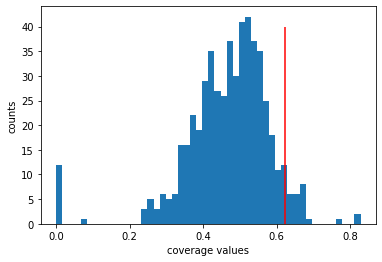

In [38]:
# Determine a threshold to filter out loci
print('Quantiles of coverage: '+str(np.quantile(a=coverage_chr['coverage'],q=np.arange(0,1,0.05))))
threshold = np.quantile(a=coverage_chr['coverage'],q=0.95)
plt.figure()
plt.hist(coverage_chr['coverage'],50)
plt.vlines(x=threshold, ymin=0, ymax=40, color='red')
plt.xlabel('coverage values')
plt.ylabel('counts')
plt.show()

In [39]:
# Select loci to filter out
regions2filter = coverage_chr[coverage_chr['coverage'] >= threshold]['start'].values

In [40]:
# Filter repeats
df.loc[regions2filter,:] = 0

## Filter out repeat regions of chr2

In [41]:
# Create dataframe of all possible start sites for this chr
chr2_size = int(df_sizes[df_sizes['chr']==str(chr2)]['size'])
start_regions = range(0, chr2_size, resol)
df_chr = pd.DataFrame({'chr':['chr' + str(chr2)]*len(start_regions), 'start':start_regions})
df_chr['stop'] = df_chr['start'] + resol
df_chr_bed = pybedtools.BedTool.from_dataframe(df_chr)
df_chr.head()

,chr,start,stop
0,chr11,0,250000
1,chr11,250000,500000
2,chr11,500000,750000
3,chr11,750000,1000000
4,chr11,1000000,1250000


In [42]:
# Compute coverage
coverage_chr = df_chr_bed.coverage(df_repeats_bed).to_dataframe(names = ['chr', 'start', 'end', 'bases covered', 
                                                                         'length intersection', 'length locus', 
                                                                         'coverage'])
coverage_chr.head()

,chr,start,end,bases covered,length intersection,length locus,coverage
0,chr11,0,250000,349,99218,250000,0.396872
1,chr11,250000,500000,469,106910,250000,0.427640
2,chr11,500000,750000,490,100259,250000,0.401036
3,chr11,750000,1000000,387,78491,250000,0.313964
4,chr11,1000000,1250000,226,57837,250000,0.231348


Quantiles of coverage: [0.       0.328112 0.3648   0.397052 0.421372 0.440816 0.456512 0.469876
 0.480552 0.491324 0.503352 0.51554  0.527356 0.53812  0.549892 0.567492
 0.577856 0.591216 0.611532 0.643524]


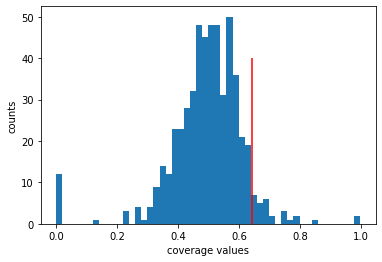

In [43]:
# Determine a threshold to filter out loci
print('Quantiles of coverage: '+str(np.quantile(a=coverage_chr['coverage'],q=np.arange(0,1,0.05))))
threshold = np.quantile(a=coverage_chr['coverage'],q=0.95)
plt.figure()
plt.hist(coverage_chr['coverage'],50)
plt.vlines(x=threshold, ymin=0, ymax=40, color='red')
plt.xlabel('coverage values')
plt.ylabel('counts')
plt.show()

In [44]:
# Select loci to filter out
regions2filter = coverage_chr[coverage_chr['coverage'] >= threshold]['start'].values

In [45]:
# Filter repeats
df.loc[:,regions2filter] = 0

## Plot Hi-C

/home/louiscam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


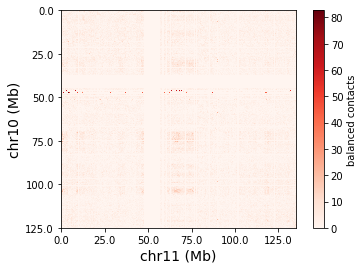

In [46]:
# Plot matrix
data = df.as_matrix()
plt.figure()
plt.imshow(data, cmap = 'Reds')
cbar = plt.colorbar()
cbar.set_label('balanced contacts')
cbar.solids.set_rasterized(True)

# label ticks with genomic position (Mb)
xaxis = range(0, df.shape[1], 100)
xlabels = [str(map_colnum2pos(df, x)/1000000.0) for x in xaxis]
plt.xticks(xaxis, xlabels)
yaxis = range(0, df.shape[0], 100)
ylabels = [str(map_rownum2pos(df, y)/1000000.0) for y in yaxis]
plt.yticks(yaxis, ylabels)

plt.xlabel('chr' + str(chr2) + ' (Mb)', fontsize = 14)
plt.ylabel('chr' + str(chr1) + ' (Mb)', fontsize = 14)

plt.show()

In [47]:
# ToDo: do it for chromosome chr2, and actually for all chromosomes at the same time so that we have a unique
# threshold used for every chromosome in order to filter out repeats

# Filter out outliers

In [48]:
# Define function to detect upper outliers (value greater than 75th percentile + 1.5IQR)
def detect_upper_outliers(arr):
    p25 = np.percentile(arr, 25)
    p75 = np.percentile(arr, 75)
    upper = p75 + 1.5*(p75-p25)
    return upper

In [49]:
# Log transform df
df_transformed = np.log(1+df)
df_transformed.head()

,0,250000,500000,750000,1000000,1250000,1500000,1750000,2000000,2250000,...,132750000,133000000,133250000,133500000,133750000,134000000,134250000,134500000,134750000,135000000
0,4.152706,2.856322,2.855208,2.281766,1.884402,2.974521,1.962390,2.022895,2.500478,0.000000,...,1.870582,0.000000,0.000000,1.678824,1.883130,1.499239,1.159687,1.598416,1.852900,0.0
250000,2.751617,2.715527,2.448582,2.285441,2.080270,0.846985,1.403814,2.026447,1.474823,1.562315,...,0.651856,0.000000,0.728183,1.159570,1.052790,1.680023,1.457886,1.601682,0.000000,0.0
500000,2.445225,2.865210,1.744627,2.492921,2.246325,1.849859,1.815672,1.874659,1.707964,1.899870,...,0.000000,0.000000,0.000000,0.742001,1.738541,0.630104,0.000000,1.095701,1.312275,0.0
750000,1.674105,2.252722,1.768006,1.716649,1.916454,1.873727,1.655203,1.482982,1.201050,1.923953,...,1.065055,0.000000,0.000000,0.000000,1.074789,1.707442,1.713078,0.000000,1.333005,0.0
1000000,1.697026,1.792380,1.252451,1.739787,1.699583,1.658679,1.450728,1.504801,1.942299,1.100260,...,1.083581,1.474233,0.000000,1.202347,1.785250,1.882878,0.774234,1.835299,0.890378,0.0


In [50]:
# Get all the row and column sums
row_orig = np.sum(df_transformed, axis = 1).as_matrix()
col_orig = np.sum(df_transformed, axis = 0).as_matrix()
# Get rid of zeros
row = row_orig[np.nonzero(row_orig)]
col = col_orig[np.nonzero(col_orig)]

/home/louiscam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/louiscam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
# Compute a threshold for outliers for chr1 and chr2
threshold_row = detect_upper_outliers(row)
threshold_col = detect_upper_outliers(col)

In [52]:
# Filter out outliers for chr1 (rows)
ind_row = np.arange(len(row_orig))[row_orig>threshold_row]
df_transformed.iloc[ind_row,:] = 0
# Filter out outliers for chr2 (columns)
ind_col = np.arange(len(col_orig))[col_orig>threshold_col]
df_transformed.iloc[:,ind_col] = 0

/home/louiscam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


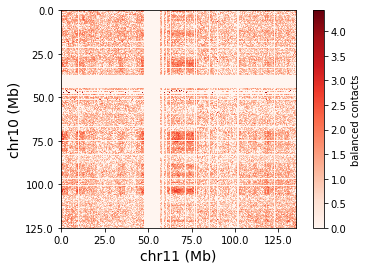

In [53]:
# Plot matrix
data = df_transformed.as_matrix()
plt.figure()
plt.imshow(data, cmap = 'Reds')
cbar = plt.colorbar()
cbar.set_label('balanced contacts')
cbar.solids.set_rasterized(True)

# label ticks with genomic position (Mb)
xaxis = range(0, df_transformed.shape[1], 100)
xlabels = [str(map_colnum2pos(df_transformed, x)/1000000.0) for x in xaxis]
plt.xticks(xaxis, xlabels)
yaxis = range(0, df_transformed.shape[0], 100)
ylabels = [str(map_rownum2pos(df_transformed, y)/1000000.0) for y in yaxis]
plt.yticks(yaxis, ylabels)

plt.xlabel('chr' + str(chr2) + ' (Mb)', fontsize = 14)
plt.ylabel('chr' + str(chr1) + ' (Mb)', fontsize = 14)

plt.show()